# Problems
1. Do not have level of tags
2. Do not have related questions
3. We only have answer "name" not answer "value" (which we want)
4. Sometimes we get the following: "Expecting value: line 1 column 1 (char 0)" (I have implemented that the API just retries because there is no problem with the call.)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
from datetime import datetime
from drhwrapper import DRHWrapper

drh = DRHWrapper("staging.religiondatabase.org/public-api")

# Example Analysis 1
## Buddhist traditions in the Database of Religious History
First, let us get an overview. How many entries (in total) are in the DRH?

In [2]:
listed_entries = drh.list_entries(to_dataframe=False, limit=10)
print(f"Total entries in the DRH {datetime.today().strftime('%Y-%m-%d')}: {listed_entries['count']}")

Total entries in the DRH 2024-05-15: 1399


We can get the metadata for all entries in the DRH with the following call

In [3]:
entry_df = drh.list_entries(to_dataframe=True, limit=2000) 

Let us check out what we have in the entry_df object

In [4]:
entry_df.dtypes

entry_id         int64
entry_name      object
expert_id        int64
expert_name     object
poll_id          int64
poll_name       object
date_created    object
year_from        int64
year_to          int64
region_id        int64
region_name     object
tags            object
dtype: object

In [5]:
entry_df.head(3)

,entry_id,entry_name,expert_id,expert_name,poll_id,poll_name,date_created,year_from,year_to,region_id,region_name,tags
0,15,Northern Song,73,Sarah Primmer,8,Polity,2014-04-17T05:00:00Z,960,1127,113,Northern Song,"[{'id': 2, 'name': 'Asia'}, {'id': 7, 'name': ..."
1,23,Late Shang Religion,22,Clayton Ashton,35,Religious Group (v5),2014-04-17T05:00:00Z,-1250,-1045,7,Middle and Lower Yellow River Valley,"[{'id': 8, 'name': 'Religious Group'}, {'id': ..."
2,173,Johannine Christianity,155,Rikard Roitto,35,Religious Group (v5),2014-11-27T22:05:55Z,90,120,483,Ephesus,"[{'id': 8, 'name': 'Religious Group'}, {'id': ..."


In [6]:
entry_df['tags'][11]

[{'id': 8, 'name': 'Religious Group'},
 {'id': 14, 'name': 'Buddhist Traditions'},
 {'id': 65, 'name': 'Chinese Buddhist Traditions'},
 {'id': 123, 'name': 'Chinese Religion'},
 {'id': 383, 'name': 'Chinese Buddhist Traditions'}]

We will get the tags out such that we can more easily access all entries that are tagged with "Buddhist Traditions"

In [9]:
# extract region tags
region_df = drh.extract_entry_tags(entry_df)
region_df.head(5)

,entry_id,entry_name,entry_tag_id,entry_tag_name
0,15,Northern Song,2,Asia
0,15,Northern Song,7,Polity
1,23,Late Shang Religion,8,Religious Group
1,23,Late Shang Religion,123,Chinese Religion
2,173,Johannine Christianity,8,Religious Group


Now we extract only the entries that have the "Buddhist Traditions" tag.

In [13]:
buddhist_regions = region_df[
    region_df["entry_tag_name"] == "Buddhist Traditions"
]
buddhist_ids = buddhist_regions["entry_id"].unique()

In [14]:
buddhist_entries = entry_df[entry_df["entry_id"].isin(buddhist_ids)]

In [15]:
buddhist_entries.sort_values(by='year_from').head(2)

,entry_id,entry_name,expert_id,expert_name,poll_id,poll_name,date_created,year_from,year_to,region_id,region_name,tags
407,820,"West Bengal, India",970,Joel Bordeaux,43,Religious Group (v6),2020-06-19T03:19:21.323560Z,-1200,-300,996,West Bengal,"[{'id': 8, 'name': 'Religious Group'}, {'id': ..."
331,726,Early Śramaṇas,791,Chris Haskett,43,Religious Group (v6),2019-11-09T06:52:48.639043Z,-700,500,934,Mahajanapadas,"[{'id': 8, 'name': 'Religious Group'}, {'id': ..."


## Overview temporal span 

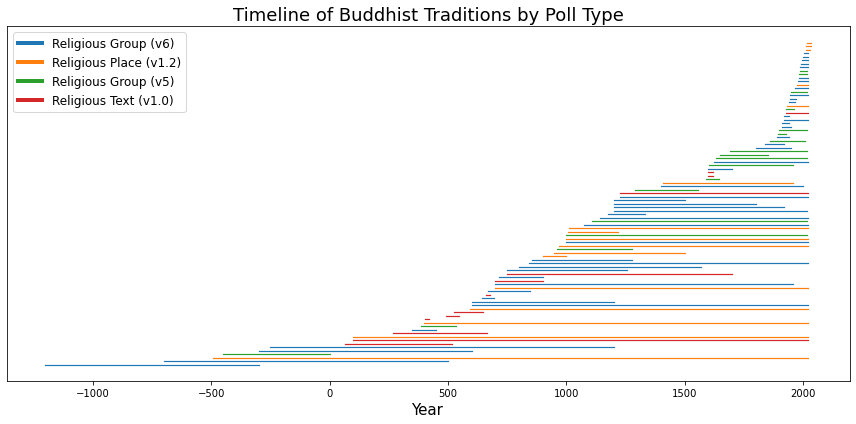

In [16]:
# plot timespan for buddhist traditions
buddhist_entries = buddhist_entries.sort_values(by="year_from").reset_index(drop=True)

# Plot setup
fig, ax = plt.subplots(figsize=(12, 6))

# Create a color map for the different poll types
# colors = plt.cm.get_cmap("tab10", buddhist_entries["poll_name"].nunique())
colors = plt.colormaps['tab10']

# Assign colors
color_map = {
    poll_type: colors(i)
    for i, poll_type in enumerate(buddhist_entries["poll_name"].unique())
}

# Create evenly spaced y-values for the lines
y_values = range(len(buddhist_entries))

# Plot each line using y_values for the y-coordinate
for y, row in zip(y_values, buddhist_entries.itertuples()):
    # Set year_to to year_from + 20 if the difference is less than 20 years
    # Just done for visibility (e.g., of texts that lack temporal extent)
    year_to = row.year_to if (row.year_to - row.year_from) >= 20 else row.year_from + 20
    ax.plot(
        [row.year_from, year_to],
        [y, y],
        color=color_map[row.poll_name],
        linewidth=1.2,
    )

# Remove y ticks and labels as they are not relevant
ax.set_yticks([])
ax.set_yticklabels([])

# Set the title and the label of the x-axis
ax.set_title("Timeline of Buddhist Traditions by Poll Type", size=18)
ax.set_xlabel("Year", size=15)

# Create a custom legend
custom_lines = [
    plt.Line2D([0], [0], color=color_map[ptype], lw=4)
    for ptype in buddhist_entries["poll_name"].unique()
]
ax.legend(custom_lines, buddhist_entries['poll_name'].unique(), fontsize='large', handlelength=2)

plt.tight_layout()
plt.show()


## Overview spatial distribution
We currently only have region ID in the dataframe that we are working with. There are 2 ways to get the full region information:

1. The `list_regions()` method will give us region information. 
2. The `dataframe_fron_entry_id_list()` will give us all data for an entry (including answersets, region information, etc.). 

If we only need the region information, the first approach is by far the fastest (because `dataframe_from_entry_id_list()` needs to iterate over all entries under the hood). We will eventually need to call `dataframe_from_entry_id_list()` to get the full answerset, but for now let us use `list_regions()`. 

In [17]:
# let us first get all of the regions in the DRH 
drh_regions = drh.list_regions(to_dataframe=True, limit=1400)

In [18]:
# see what we have
drh_regions.head(3)

,region_id,region_name,description,created_by_id,created_by_name,geom,tags
0,6,Ancient Mediterranean,"Ancient Mediterranean tagged with ""Western Eur...",140,Andreas Bendlin,"[[[[55.520348384170575, -20.949366318200987], ...","[{'id': 3, 'name': 'Europe'}, {'id': 296, 'nam..."
1,7,Middle and Lower Yellow River Valley,Middle and Lower Yellow River Valley + Areas o...,22,Clayton Ashton,"[[[[108.66096496582, 34.34326171875], [116.184...","[{'id': 1, 'name': 'Asia'}, {'id': 37, 'name':..."
2,10,Qin Dynasty boundaries,Qin Dynasty boundaries,3,Carson Logan,"[[[[120.41260643779995, 27.15313777327598], [1...","[{'id': 1, 'name': 'Asia'}, {'id': 37, 'name':..."


In [19]:
# select needed columns (we only really need the geom here to plot the regions on a map)
drh_regions = drh_regions[["region_id", "geom"]]

# merge with buddhist entries
buddhist_entries_regions = buddhist_entries.merge(drh_regions, on = 'region_id', how = 'inner')

In [20]:
# Function to convert nested lists to Polygon
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
# Function to convert nested lists to Polygon using Shapely 2.0
def convert_to_polygon(nested_list):
    # Adjust the indexing based on your actual data structure
    if nested_list:
        outer_list = nested_list[0][0]  # Extract the first list of coordinates
        return Polygon(outer_list)
    return None

# Convert the 'geom' data to Shapely polygons
buddhist_entries_regions['geometry'] = buddhist_entries_regions['geom'].apply(convert_to_polygon)

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(buddhist_entries_regions, geometry='geometry')

/tmp/ipykernel_42503/721378956.py:2: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


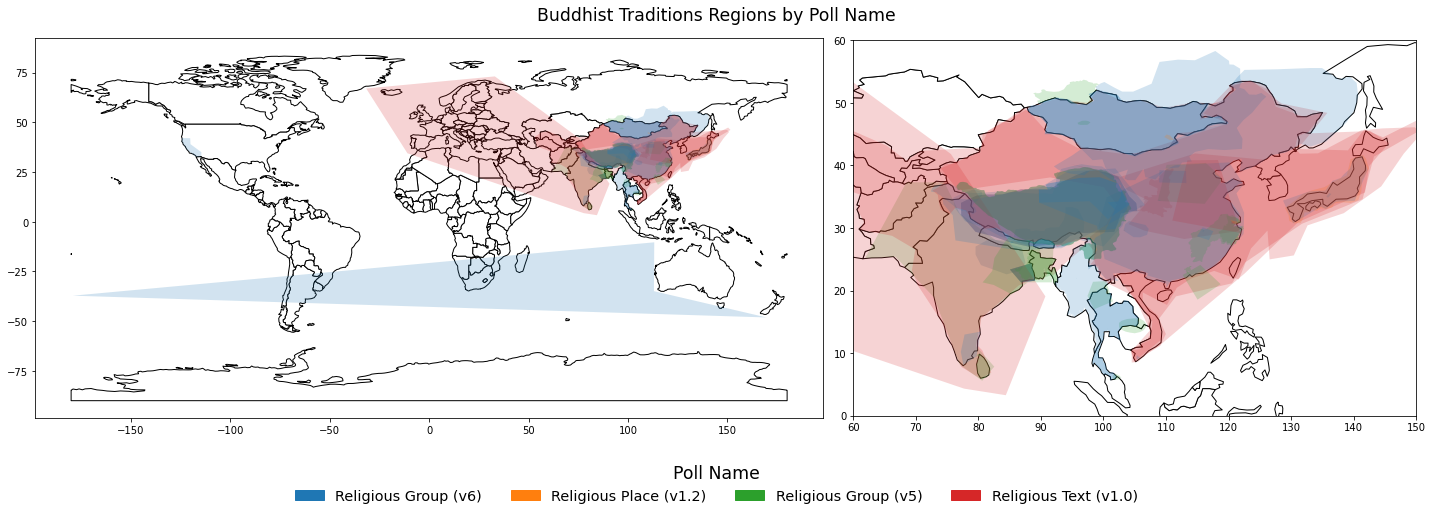

In [21]:
# Load simple world map 
import warnings
import matplotlib.gridspec as gridspec
warnings.simplefilter(action='ignore', category=FutureWarning)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Define a figure and a gridspec with width ratios
fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2.8, 2])  # Adjust width ratios as needed

# Assign subplots to the gridspec slots
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Create a colormap for the unique poll names
poll_names = gdf['poll_name'].unique()
colors = plt.colormaps['tab10'] #colors = plt.cm.get_cmap('viridis', len(poll_names))
color_dict = {name: colors(i) for i, name in enumerate(poll_names)}

# Plot the world map on the first subplot
world.plot(ax=ax1, color='white', edgecolor='black')
# Plot your GeoDataFrame on the first subplot with colors based on 'poll_name'
gdf.plot(ax=ax1, color=[color_dict[name] for name in gdf['poll_name']], alpha=0.2)

# Plot the world map on the second subplot
world.plot(ax=ax2, color='white', edgecolor='black')
# Plot your GeoDataFrame on the second subplot
gdf.plot(ax=ax2, color=[color_dict[name] for name in gdf['poll_name']], alpha=0.2)

# Set the limits for the second subplot to zoom into a specific region
ax2.set_xlim(60, 150)
ax2.set_ylim(0, 60)

# Title
fig.suptitle('Buddhist Traditions Regions by Poll Name', fontsize='xx-large')

# Improve layout
plt.tight_layout()

# Create a legend for the whole figure
from matplotlib.patches import Patch
handles = [Patch(color=color_dict[name], label=name) for name in poll_names]
fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(poll_names), title='Poll Name', title_fontsize='xx-large', fontsize='x-large', frameon=False)

# Display the plots
plt.show()

We have a few regions that cross the anti-meridian. These will look weird when displayed on a map, but will not affect analysis.

## Answersets
The dataframe we have currently only holds metadata for the entries (e.g., name, id, expert, timespan, etc.)
If we want the full answerset, we will need to use a different endpoint. Here we are iteratively calling the API for each entry (under the hood) so it makes sense to only extract the entries that we are interested in. The method `dataframe_from_entry_id_list` takes a list of `entry ID` and returns a dataframe with the information that we need. (*NB: the following will take a few minutes to run*)

In [23]:
buddhist_entries = buddhist_entries.sort_values(by="entry_id").reset_index(drop=True)
buddhist_ids = buddhist_entries["entry_id"].unique()
buddhist_answer_data = drh.dataframe_from_entry_id_list(buddhist_ids)

100%|██████████| 93/93 [07:04<00:00,  4.57s/it]


In [32]:
# save data for later (entry_references not saved correctly, but the rest is okay)
# buddhist_answer_data.to_parquet('buddhist_answer_data.parquet', engine='pyarrow')
# buddhist_answer_data = pd.read_parquet('buddhist_answer_data.parquet', engine='pyarrow')

In [43]:
# check some of the key columns
buddhist_answer_data[['entry_id', 'entry_name', 'year_from', 'year_to', 'poll', 'tags', 'categories']].head(2)

,entry_id,entry_name,year_from,year_to,poll,tags,categories
0,184,Chinese Buddhism (Northern Wei),386,534,"{'id': 35, 'name': 'Religious Group (v5)', 'de...","[{'id': 8, 'name': 'Religious Group'}, {'id': ...","[{'id': 66, 'name': 'Sources', 'groups': [], '..."
1,186,Buddhism (Late Ming),1590,1644,"{'id': 35, 'name': 'Religious Group (v5)', 'de...","[{'id': 8, 'name': 'Religious Group'}, {'id': ...","[{'id': 66, 'name': 'Sources', 'groups': [], '..."


The column `categories` is a list of dictionaries that hold all of the answers. However, it is not straight forward to extract this because of the hierarchical nature of the polls. We can use the helper method `extract_answer_information` to do that.

In [44]:
buddhist_answers_expanded = drh.extract_answer_information(buddhist_answer_data)
buddhist_answers_expanded.dtypes

entry_id                 int64
entry_name              object
question_set_id          int64
question_set_name       object
question_group_id        Int64
question_group_name     object
question_id              int64
question_name           object
parent_question_id       Int64
answer_set_id            int64
answer_set_year_from     int64
answer_set_year_to       int64
answer_set_region_id     int64
answer_id                int64
answer_name             object
answer_text             object
notes                   object
dtype: object

In [45]:
# we will need the following
# NB: here we should have answer_value but this has not been implemented yet
buddhist_answers_expanded[["entry_id", "entry_name", "question_id", "question_name", "answer_name"]].head(5)

,entry_id,entry_name,question_id,question_name,answer_name
0,184,Chinese Buddhism (Northern Wei),2316,Are other religious groups in cultural contact...,Yes
1,184,Chinese Buddhism (Northern Wei),2349,Does the religious group have a general proces...,Yes
2,184,Chinese Buddhism (Northern Wei),2284,Assigned by personal choice:,Yes
3,184,Chinese Buddhism (Northern Wei),2262,Assigned by participation in a particular ritual:,Yes
4,184,Chinese Buddhism (Northern Wei),2300,Does the religion have official political support,Yes


The variables differ by poll type, so let us merge with this information

In [46]:
buddhist_polls = buddhist_entries[["entry_id", "poll_name"]].drop_duplicates()
buddhist_answers_polls = buddhist_answers_expanded.merge(
    buddhist_polls, on="entry_id", how="inner"
)

In [47]:
# extract question that we are interested in 
social_norms = buddhist_answers_polls[
    buddhist_answers_polls["question_name"].str.contains("general social norms")
]

# check what we have 
pd.set_option('display.max_colwidth', None)
social_norms[['question_name', 'question_id', 'poll_name']].drop_duplicates()

,question_name,question_id,poll_name
580,Are general social norms prescribed by the religious group:,3028,Religious Group (v5)
4527,Are general social norms prescribed by the religious group:,5077,Religious Group (v6)
15411,Are general social norms prescribed by the text?,8271,Religious Text (v1.0)


In [48]:
# how many (Buddhist Traditions) entries have answers for these questions?
unique_entries = social_norms["entry_id"].nunique()
print(f"Unique entries: n={unique_entries}")

Unique entries: n=64


In [49]:
# distribution of answers
social_norms.groupby("answer_name").size().reset_index(name="count")

,answer_name,count
0,I don't know,1
1,No,14
2,Yes,49


In [50]:
# let us focus on the "No" and "Yes" answers for now
social_norms_binary = social_norms[social_norms["answer_name"].isin(["No", "Yes"])]

In [22]:
# let us see whether there are patterns in the responses
# first think we might consider is whether groups and texts are different
social_norms_binary.groupby(["poll_name", "answer_name"]).size().reset_index(name="count")

,poll_name,answer_name,count
0,Religious Group (v5),Yes,13
1,Religious Group (v6),No,3
2,Religious Group (v6),Yes,34
3,Religious Text (v1.0),No,11
4,Religious Text (v1.0),Yes,2


- for "texts" the answer is mostly "No" (11-to-2)
- for "groups" (aggregated) the answer is mostly "Yes" (57-to-3)

this seems most likely to reflect that a religious group can have general norms prescribed without it being mentioned in a specific text.

Let us nonetheless explore spatial and temporal trends ... 

In [51]:
# smooth time intervals 
def smooth_time_intervals(df, bin_width, step_size):
    df_smoothed = pd.DataFrame()
    min_year, max_year = df["answer_set_year_from"].min(), df["answer_set_year_to"].max()
    adjusted_max_year = max_year - bin_width + 1
    bins = range(min_year, adjusted_max_year + 1, step_size)

    for start in bins:
        end = start + bin_width
        mask = (df["answer_set_year_from"] <= end) & (df["answer_set_year_to"] >= start)
        temp_df = df.loc[mask].copy()
        temp_df["time_bin"] = np.mean([start, end])
        df_smoothed = pd.concat([df_smoothed, temp_df])

    return df_smoothed

# 500 year bins, 100 year step size 
df_time_intervals = smooth_time_intervals(social_norms_binary, bin_width=500, step_size=100)

In [52]:
# select columns that we need
df_time_intervals = df_time_intervals[["entry_id", "entry_name", "question_id", "question_name", "answer_set_year_from", "answer_set_year_to", "time_bin", "poll_name", "answer_name"]]

# recode answer_name from Yes/No to 1/0
df_time_intervals['answer_value'] = df_time_intervals['answer_name'].apply(lambda x: 1 if x == 'Yes' else 0)

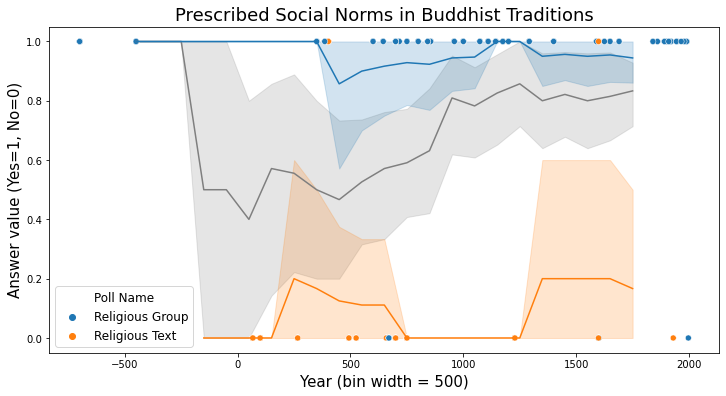

In [55]:
# code polls into "Group" and "Text"
df_time_intervals['poll_name'] = df_time_intervals['poll_name'].apply(lambda x: "Religious Group" if "Group" in x else "Religious Text")

# plot the data
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=df_time_intervals, x='time_bin', y='answer_value', color='tab:grey')
sns.lineplot(data=df_time_intervals[df_time_intervals['poll_name']=='Religious Group'], x='time_bin', y='answer_value', color='tab:blue')
sns.lineplot(data=df_time_intervals[df_time_intervals['poll_name']=="Religious Text"], x='time_bin', y='answer_value', color='tab:orange')
sns.scatterplot(data=df_time_intervals, x='answer_set_year_from', y='answer_value', hue='poll_name')
plt.xlabel("Year (bin width = 500)", size=15)
plt.ylabel("Answer value (Yes=1, No=0)", size=15)
plt.title("Prescribed Social Norms in Buddhist Traditions", size=18)
plt.legend(title='Poll Name', fontsize='large', title_fontsize='large')
plt.show();

It does look like there is a temporal trend (towards more prescription of general social norms) but it is not clear whether this is a genuine shift within Buddhist Traditions, or whether this is an artefact of more "Religious Groups" being more recent, whereas more "Religious Texts" are older. 